# Excess properties for a polar-inert mixture

In this document we compare excess properties calculated by our `SAC` implementation for a polar-inert system. The pair interaction energies are the same as given by [Egner et al. (1997)](https://doi.org/10.1002/bbpc.19971010208). These energies are set to make the system behave similarly to the acetone/-n-heptane mixture.

We start by importing the necessary packages.

In [1]:
import math, os, sys
import matplotlib.pyplot as plt
import pandas as pd

parent_directory = os.path.dirname(os.path.abspath('.'))
sys.path.append(parent_directory)

from pysac import SAC, RGAS, RGAS_SI, DEFAULT_Q_EFF

## Compound definitions

Ther original article considered a simple-cubic lattice (z = 6). Then, in order to compare the results with the cubic lattice system we need to set the areas with 6 segments each.


In [2]:
Q_eff = DEFAULT_Q_EFF;
Q_1   = [3*Q_eff, 3*Q_eff]
Q_2   = [6*Q_eff]

# The mixture area
Q = [Q_1, Q_2]
nu = 6

## Interaction energies

It is assumed that the polar compound has two types of segments: interaction between segment types 1 and 2 is attractive; between 1 and 1 or 2 and 2 is repulsive. The interaction energies with the inert compound segments are always zero.

In [3]:
T0 = 300

class EgnerPolarInert(SAC):
    def __init__(self):
        super().__init__(Q_eff=Q_eff, tol=1e-10)

    # Interaction energies according to Table 3 of the original article
    def calc_u(self, T, i, j, m, n):
        if i == 1 or j == 1:
            # no interaction with inert compound
            return 0
        if (m == n):
            # e11 and e22
            return 340 * RGAS
        
        # e12 and e21
        return -340 * RGAS

# Create an instance of our SAC class
sac = EgnerPolarInert()

# Set a temperature, we use the reference `T0` so we get the same
# results as in the original work.
T = T0
sac.set_compounds(Q)
sac.set_temperature(T)

## Excess properties

Here we calculate the excess properties on multiple compositions and compare our results with Monte-Carlo simulations from the original article.

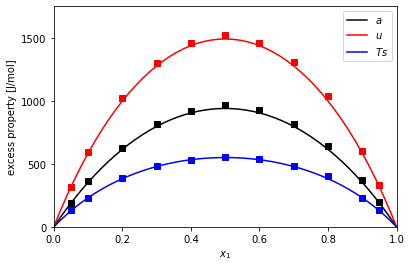

In [4]:
N = 51
ue = []
ae = []
tse = []

# Monte-Carlo data from Fig. 6 (image recognition) of the original work
x1_exp = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
ge_exp = [189, 362.4, 625.9, 819.7, 923.6, 965.4, 930.6, 819.8, 639.8, 369.4, 195.9]
he_exp = [320.7, 598.1, 1021.1, 1298, 1462, 1519.7, 1462, 1307.9, 1038.5, 606, 336.6]
tse_exp = [133.78, 230.73, 390.3, 487.2, 528.5, 556.3, 535.4, 487.2, 403.7, 230.7, 133.8]

x1 = []

for l in range(N):
    x1_ = l/(N-1)
    x1.append(x1_)

    x = [x1_, 1-x1_]
    
    sac.set_composition(x)
    sac.calc_ln_gamma()

    ae_ = sac.get_helmholtz()
    #print(ae_ - sac.get_helmholtz2())
    ue_ = sac.get_energy()
    se_ = sac.get_entropy()

    # subtract the pure compound energies to get the excess
    for i in range(len(x)):
        ue_ -= x[i]*sac.get_energy_pure(i)
        ae_ -= x[i]*sac.get_helmholtz_pure(i)
        se_ -= x[i]*sac.get_entropy_pure(i)
    
    ae.append(ae_ * RGAS_SI * T)
    ue.append(ue_ * RGAS_SI * T)
    #tse.append((ue_ - ae_) * RGAS_SI * T)
    tse.append(se_ * RGAS_SI * T)

    #print(se_ - (ue_ - ae_))

plt.plot(x1_exp, ge_exp, 'ks')
plt.plot(x1_exp, he_exp, 'rs')
plt.plot(x1_exp, tse_exp, 'bs')
plt.plot(x1, ae, 'k-', label=r'$a$')
plt.plot(x1, ue, 'r-', label=r'$u$')
plt.plot(x1, tse, 'b-', label=r'$Ts$')

plt.legend(loc='upper right')
plt.xlabel(r'$x_1$')
plt.ylabel(r'excess property [J/mol]')
plt.xlim([0, 1])
plt.ylim([0, 1750])
#plt.ylim([-0.6, 0.6])

plt.rcParams.update({'font.size': 16})
plt.tight_layout()
plt.plot()
plt.savefig('pdf/egner_polar_inert.pdf')

## Explaining the positive excess entropy

Preferential contacts generate negative contributions to the residual entropy.

For the present case, the polar compound has a higher order (nonrandomness) when pure than when in mixture. Compound 2 has no preferential interactions when pure, so zero residual entropy.

In [5]:
x = [0.5, 0.5]
sac.set_composition(x)
sac.calc_ln_gamma()

print("0.5 mol of pure compound 1, T*s [J]: ", x[0]*sac.get_entropy_pure(0) * RGAS_SI*T)
print("0.5 of pure compound 2, T*s [J]: ", x[1]*sac.get_entropy_pure(1) * RGAS_SI*T)
print("Equimolar mixture, T*s [J/mol]: ", sac.get_entropy() * RGAS_SI*T)
print("Equimolar mixture excess, T*s [J/mol]: ", (sac.get_entropy()-x[0]*sac.get_entropy_pure(0)-x[1]*sac.get_entropy_pure(1)) * RGAS_SI*T)

0.5 mol of pure compound 1, T*s [J]:  -1427.8685181170763
0.5 of pure compound 2, T*s [J]:  0.0
Equimolar mixture, T*s [J/mol]:  -876.8056302184567
Equimolar mixture excess, T*s [J/mol]:  551.0628878986196


### Pair contact entropy contributions for pure compound 1

We can investigate the *order* using the individual contributions to the residual entropy of every pair contact in mixture.

When pure, compound 1 has a preferential (attractive) contact between segments 1-2. This generates a strong negative residual entropy contribution for the pairs (1-2 and 2-1).

In [6]:
print("Entropy terms (times T) for 0.5 mols of pure compound 1 [J]:")
i = j = 0
alpha = sac.get_nonrandom_pure(i)
theta_i = sac.theta_pure[i]
seg_gamma_i = sac.seg_gamma_pure[i]
theta_j = sac.theta_pure[j]
seg_gamma_j = sac.seg_gamma_pure[j]
psi_ij = sac.psi[i][j]
for m in range(len(theta_i)):
    for n in range(len(theta_j)):
        alpha_mn = seg_gamma_i[m] * seg_gamma_j[n] * psi_ij[m][n]
        si = -nu/2 * theta_i[m]*theta_j[n] * alpha_mn * (math.log(alpha_mn)) * RGAS_SI*T

        print(f"segments {m+1}-{n+1}: {x[0]*si}")

Entropy terms (times T) for 0.5 mols of pure compound 1 [J]:
segments 1-1: 293.8032823224299
segments 1-2: -1007.737532539546
segments 2-1: -1007.737532539546
segments 2-2: 293.8032646395858


### Pair contact entropy contributions for an equimolar mixture

When in an equimolar mixture with an inert compound, the preferential compound 1 contacts (1-2 and 2-1)
become less likely and their negative residual entropy contribution is reduced. This, along with other smaller positive contributions for contacts with compound 2, lead to a positive excess entropy.

Note the preferential contact between neutral segments of compound 2. This produces a negative contribution to the miture residual entropy, but still not enough to make the excess entropy negative.

In [7]:
print("\nEntropy terms (times T) for 0.5 mols of each compound [J]:")
for i in range(sac.ncomps):
    theta_i = sac.theta[i]
    seg_gamma_i = sac.seg_gamma[i]

    for j in range(sac.ncomps):
        theta_j = sac.theta[j]
        seg_gamma_j = sac.seg_gamma[j]

        psi_ij = sac.psi[i][j]

        print(f"Compounds: {i+1}-{j+1}")

        for m in range(len(theta_i)):
            for n in range(len(theta_j)):
                alpha = seg_gamma_i[m] * seg_gamma_j[n] * psi_ij[m][n]
                si = -nu/2 * theta_i[m]*theta_j[n] * alpha * (math.log(alpha)) * RGAS_SI*T

                print(f"segments {m+1}-{n+1}: {si}")



Entropy terms (times T) for 0.5 mols of each compound [J]:
Compounds: 1-1
segments 1-1: 154.05355397190132
segments 1-2: -692.0927456159067
segments 2-1: -692.0927456159067
segments 2-2: 154.05355483558998
Compounds: 1-2
segments 1-1: 116.45616731233804
segments 2-1: 116.45616180960346
Compounds: 2-1
segments 1-1: 116.45616731233804
segments 1-2: 116.45616180960346
Compounds: 2-2
segments 1-1: -266.55190603801753
